<a href="https://colab.research.google.com/github/MuhammedKocakKIT/cellpose/blob/main/notebooks/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

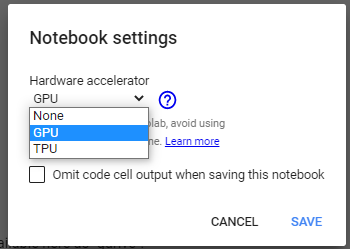

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


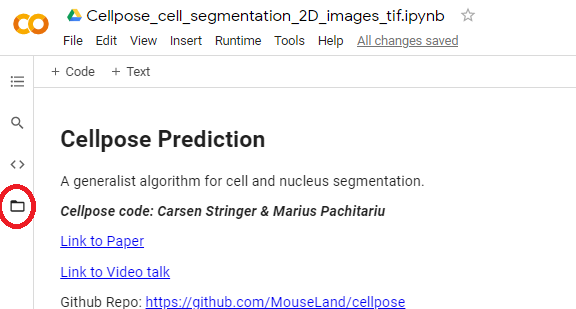

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

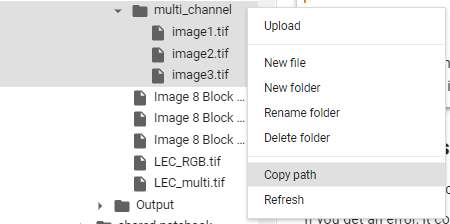

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-e5pjj7wy
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-e5pjj7wy
  Resolved https://www.github.com/mouseland/cellpose.git to commit 17fb25f40055ec2636aa708dc4cf6625b8b4735d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 105.1 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.8-py3-none-any.whl size=212051 sha256=8ddf5b1ad83a5a72d646a461513a0cedc9aa43cd7cd29520c16c5c0196501ab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-84hgd2ti/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-12-15 12:19:51,954 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-12-15 12:19:51,955 [INFO] 
cellpose version: 	4.0.8 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
2025-12-15 12:19:52,172 [INFO] ** TORCH CUDA version installed and working. **
2025-12-15 12:19:52,173 [INFO] ** TORCH CUDA version installed and working. **
2025-12-15 12:19:52,174 [INFO] >>>> using GPU (CUDA)
2025-12-15 12:19:56,605 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:24<00:00, 50.3MB/s]


Input directory with your images:

In [4]:
# *** change to your google drive folder path ***
dir = "/content/drive/MyDrive/GeologicalImageSegmentation/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

4 images in folder:
nature_rock_chip_p29_original.tif
nature_rock_chip_p29_original_gt.tif
nature_rock_chip_p29_original_mask.tif
nature_rock_chip_p29_original_qualitative.tif


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [74]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (4160, 6240, 3). Assuming channel dimension is last with 3 channels


### Kocak - Preprocessing of the images

Preprocessing the images for better segmentation accuracy

#### Kocak - Adjust cropping boundaries

In [75]:
from ipywidgets import interact, IntSlider
from IPython.display import display

def crop_and_display(x_begin, x_end, y_begin, y_end):
    global img  # Ensure img from previous cell is accessible
    if 'img' not in globals():
        img = io.imread(files[0]) # Load image if not already loaded in this session

    # Ensure x_end is greater than x_begin and y_end is greater than y_begin
    x_end = max(x_end, x_begin + 1)
    y_end = max(y_end, y_begin + 1)

    # Ensure cropping dimensions are within image bounds
    x_begin = max(0, x_begin)
    x_end = min(img.shape[1], x_end)
    y_begin = max(0, y_begin)
    y_end = min(img.shape[0], y_end)

    cropped_img = img[y_begin:y_end, x_begin:x_end, :]

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cropped_img)
    axes[1].set_title(f'Cropped Image (x: {x_begin}-{x_end}, y: {y_begin}-{y_end})')
    axes[1].axis('off')
    plt.show()

# Initialize sliders with reasonable default values based on the first image's shape
# Assuming img is loaded from the previous cell `vefSZf0tLxKI`

# Get image dimensions (height, width, channels)
img_height, img_width, _ = img.shape

# Default cropping values
default_x_begin = 0
default_x_end = img_width
default_y_begin = 0
default_y_end = img_height

interact(crop_and_display,
         x_begin=IntSlider(min=0, max=img_width-1, step=1, value=default_x_begin, description='X-Begin'),
         x_end=IntSlider(min=1, max=img_width, step=1, value=default_x_end, description='X-End'),
         y_begin=IntSlider(min=0, max=img_height-1, step=1, value=default_y_begin, description='Y-Begin'),
         y_end=IntSlider(min=1, max=img_height, step=1, value=default_y_end, description='Y-End')
        );

interactive(children=(IntSlider(value=0, description='X-Begin', max=6239), IntSlider(value=6240, description='…

#### Kocak - Save the cropped image

In [76]:
# @markdown ### Enter the desired cropping coordinates from the interactive visualization
final_x_begin = 1660 # @param {type:"number"}
final_x_end = 2567 # @param {type:"number"}
final_y_begin = 1212 # @param {type:"number"}
final_y_end = 2787 # @param {type:"number"}

# Ensure the original image is available. If 'original_img' is not defined,
# it will be loaded from the first file. If it is, we use the stored version.
if 'original_img' not in globals():
    original_img = io.imread(files[0])

# Ensure x_end is greater than x_begin and y_end is greater than y_begin
x_end_val = max(final_x_end, final_x_begin + 1)
y_end_val = max(final_y_end, final_y_begin + 1)

# Ensure cropping dimensions are within image bounds
x_begin_val = max(0, final_x_begin)
x_end_val = min(original_img.shape[1], x_end_val)
y_begin_val = max(0, final_y_begin)
y_end_val = min(original_img.shape[0], y_end_val)

# Perform the cropping and update the global 'img' variable
img = original_img[y_begin_val:y_end_val, x_begin_val:x_end_val, :]

print(f"Original image dimensions: {original_img.shape}")
print(f"Image successfully cropped using coordinates: X={x_begin_val}-{x_end_val}, Y={y_begin_val}-{y_end_val}")
print(f"The 'img' variable has been updated with the cropped image. New 'img' shape: {img.shape}")

Original image dimensions: (4160, 6240, 3)
Image successfully cropped using coordinates: X=1660-2567, Y=1212-2787
The 'img' variable has been updated with the cropped image. New 'img' shape: (1575, 907, 3)


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton (haha error! gotcha!) of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [77]:
first_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

2025-12-15 13:30:06,033 [INFO] processing image with (1575, 907) HW, and 3 channels


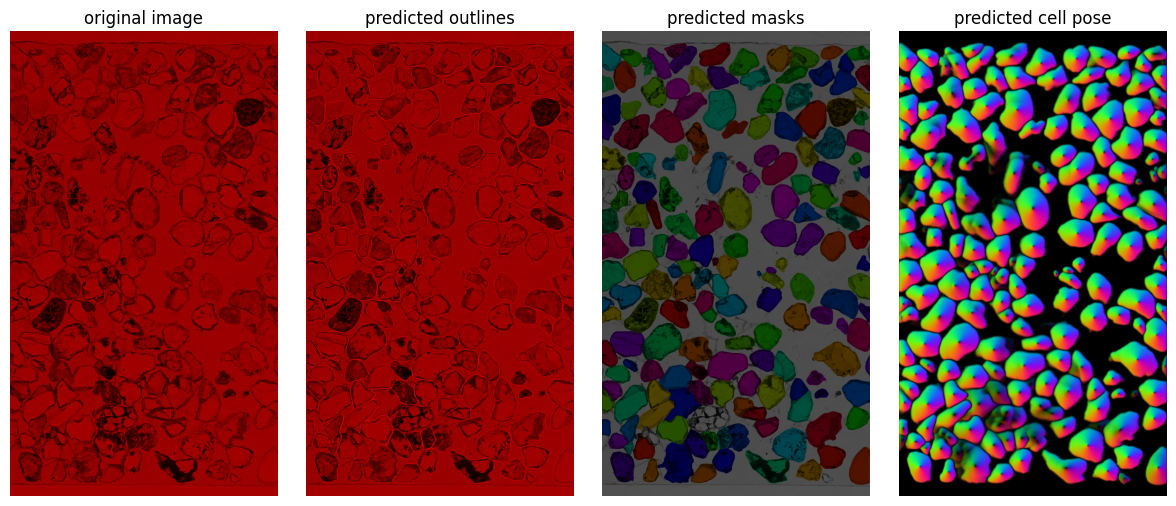

In [78]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  # Check if the image has channels to begin with
  if img.ndim > 2 and int(c) >= img.shape[-1]:
      assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  # Handle single channel image case
  if img.ndim == 2 and int(c) != 0:
      assert False, 'invalid channel index for grayscale image, must be 0 or None'
  if c != 'None':
      selected_channels.append(int(c))

# Adjust image indexing based on whether channels were selected and image dimension
if selected_channels and img.ndim > 2:
    img_selected_channels = np.zeros_like(img)
    img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]
elif img.ndim == 2:
    # If the image is grayscale, use it directly
    img_selected_channels = img
else:
    # If no channels are selected but the image has channels, use all channels
    img_selected_channels = img


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()

### Kocak - Display the segmentation masks

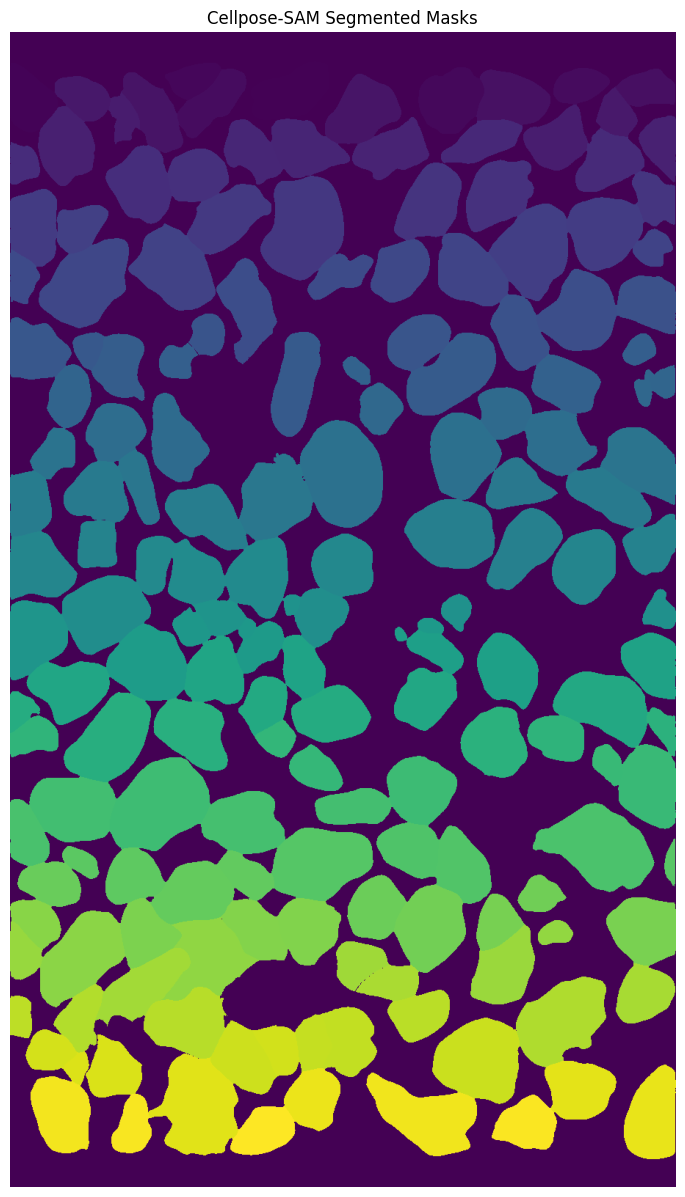

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.imshow(masks)
plt.title('Cellpose-SAM Segmented Masks')
plt.axis('off')
plt.show()

### Kocak - Save the mask for the sample image


In [80]:
output_filename = files[0].stem + '_mask' + image_ext
output_path = dir / output_filename
io.imsave(output_path, masks)
print(f"Mask saved to: {output_path}")

Mask saved to: /content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_mask.tif


## Kocak - Visualize

### Kocak - Crop the ground truth segmentation to the same size with our boundary selection

In [81]:
gt_filename = files[0].stem + '_gt' + image_ext
ground_truth_mask_original = io.imread(dir / gt_filename)

# Ensure x_end is greater than x_begin and y_end is greater than y_begin
x_end_gt = max(final_x_end, final_x_begin + 1)
y_end_gt = max(final_y_end, final_y_begin + 1)

# Ensure cropping dimensions are within ground truth image bounds
x_begin_gt = max(0, final_x_begin)
x_end_gt = min(ground_truth_mask_original.shape[1], x_end_gt)
y_begin_gt = max(0, final_y_begin)
y_end_gt = min(ground_truth_mask_original.shape[0], y_end_gt)

# Perform the cropping on the ground truth mask
ground_truth_mask = ground_truth_mask_original[y_begin_gt:y_end_gt, x_begin_gt:x_end_gt]

print(f"Original ground truth mask dimensions: {ground_truth_mask_original.shape}")
print(f"Ground truth mask successfully cropped using coordinates: X={x_begin_gt}-{x_end_gt}, Y={y_begin_gt}-{y_end_gt}")
print(f"The 'ground_truth_mask' variable has been updated with the cropped mask. New shape: {ground_truth_mask.shape}")

Original ground truth mask dimensions: (4160, 6240)
Ground truth mask successfully cropped using coordinates: X=1660-2567, Y=1212-2787
The 'ground_truth_mask' variable has been updated with the cropped mask. New shape: (1575, 907)


### Kocak - Convert ground truth and predicted mask to binary

In [82]:
# Convert ground_truth_mask to a binary mask
# The ground_truth_mask from the kernel is 16-bit, with foreground 70 and background 0
binary_ground_truth_mask = (ground_truth_mask == 70).astype(np.uint8)
print(f"Binary ground truth mask created with shape: {binary_ground_truth_mask.shape}")
print(f"Unique values in binary ground truth mask: {np.unique(binary_ground_truth_mask)}")

# Convert Cellpose-SAM mask to binary
# Cellpose-SAM 'masks' output contains unique integer labels for each segmented object.
# To create a binary mask, we set any non-zero pixel to 1.
binary_cellpose_sam_mask = (masks > 0).astype(np.uint8)
print(f"Binary Cellpose-SAM mask created with shape: {binary_cellpose_sam_mask.shape}")
print(f"Unique values in binary Cellpose-SAM mask: {np.unique(binary_cellpose_sam_mask)}")

Binary ground truth mask created with shape: (1575, 907)
Unique values in binary ground truth mask: [0 1]
Binary Cellpose-SAM mask created with shape: (1575, 907)
Unique values in binary Cellpose-SAM mask: [0 1]


### Kocak - Overlay masks on the original image

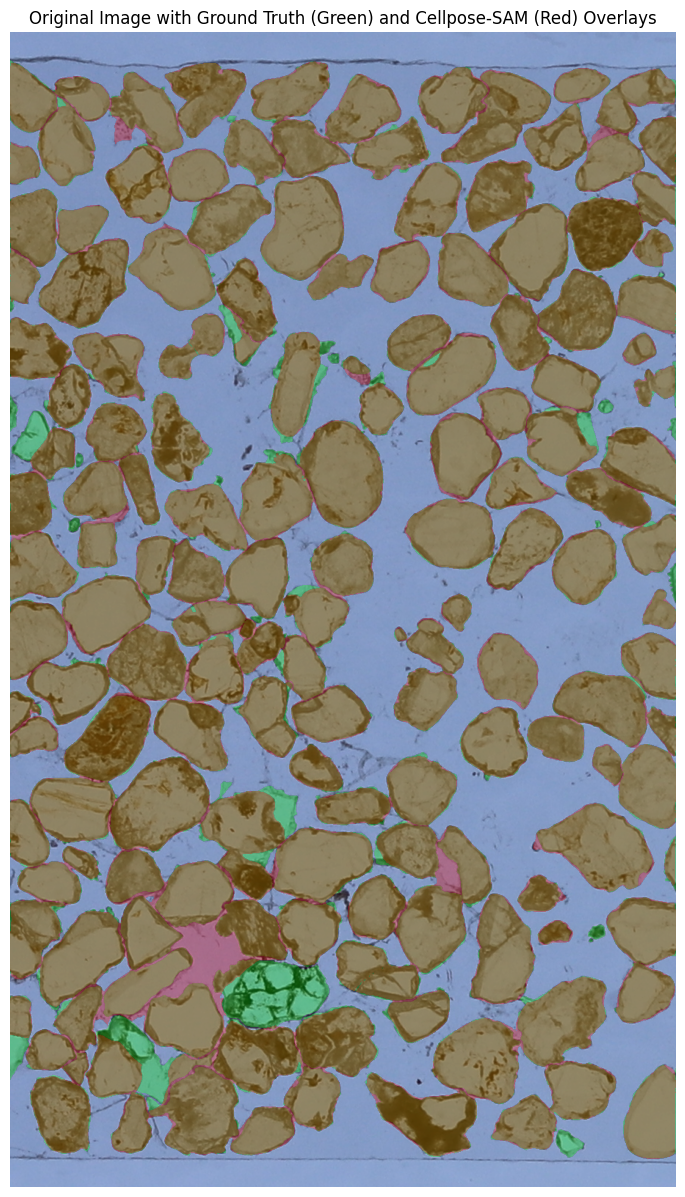

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Create a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Display the original img
ax.imshow(img)

# Create an RGBA overlay for the binary ground truth mask
gt_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_gt = 0.3  # Transparency for ground truth mask
gt_overlay_rgba[binary_ground_truth_mask == 1, 1] = 1.0  # Green channel
gt_overlay_rgba[binary_ground_truth_mask == 1, 3] = alpha_gt  # Alpha channel
ax.imshow(gt_overlay_rgba)

# Create an RGBA overlay for the binary Cellpose-SAM mask
cpsam_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_cpsam = 0.3  # Transparency for Cellpose-SAM mask
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 0] = 1.0  # Red channel
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 3] = alpha_cpsam  # Alpha channel
ax.imshow(cpsam_overlay_rgba)

# Set the title and turn off axes
ax.set_title('Original Image with Ground Truth (Green) and Cellpose-SAM (Red) Overlays')
ax.axis('off')

# Display the plot
plt.show()

### Kocak - Save the overlayed image

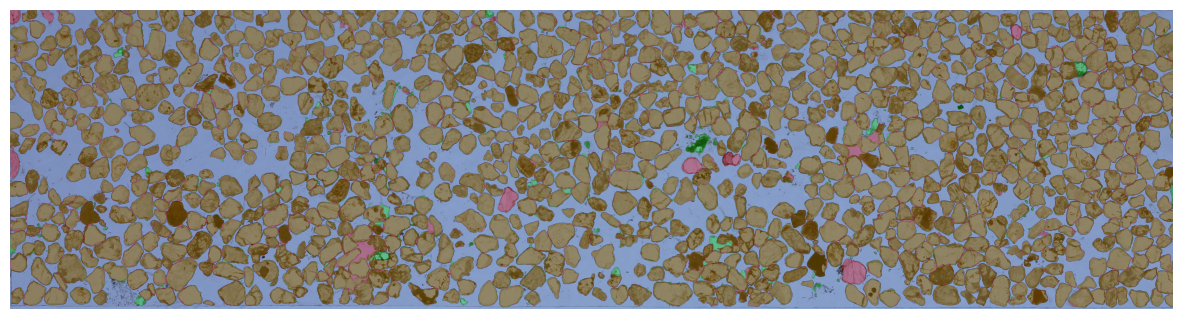

Overlayed figure saved to: /content/drive/MyDrive/GeologicalImageSegmentation/nature_rock_chip_p29_original_qualitative.tif


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Create a Matplotlib figure and axes, matching the aspect ratio of the original image
fig, ax = plt.subplots(figsize=(15, 10)) # Adjusted figsize to match img aspect ratio (6240/4160 = 1.5)

# Display the original img
ax.imshow(img)

# Create an RGBA overlay for the binary ground truth mask
gt_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_gt = 0.3  # Transparency for ground truth mask
gt_overlay_rgba[binary_ground_truth_mask == 1, 1] = 1.0  # Green channel
gt_overlay_rgba[binary_ground_truth_mask == 1, 3] = alpha_gt  # Alpha channel
ax.imshow(gt_overlay_rgba)

# Create an RGBA overlay for the binary Cellpose-SAM mask
cpsam_overlay_rgba = np.zeros((*img.shape[:2], 4), dtype=np.float32)
alpha_cpsam = 0.3  # Transparency for Cellpose-SAM mask
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 0] = 1.0  # Red channel
cpsam_overlay_rgba[binary_cellpose_sam_mask == 1, 3] = alpha_cpsam  # Alpha channel
ax.imshow(cpsam_overlay_rgba)

# Remove the title and turn off axes for a cleaner visualization
ax.set_title('')
ax.axis('off')

# Calculate DPI to match original image resolution
# Original image dimensions: img.shape[1] (width), img.shape[0] (height)
# Figure size: 15 inches (width), 10 inches (height)
dpi = img.shape[1] / 15 # or img.shape[0] / 10

# Save the figure as a TIFF image with the calculated DPI
output_filename = files[0].stem + '_qualitative.tif'
output_path = dir / output_filename
plt.savefig(output_path, dpi=dpi, bbox_inches='tight', pad_inches=0)

# Display the plot
plt.show()
print(f"Overlayed figure saved to: {output_path}")

## Kocak - Quantitative evaluation

In [73]:
import numpy as np

# --- 0/1 binary masks you already have ---
gt_bin = (binary_ground_truth_mask > 0).astype(np.uint8)
pr_bin = (binary_cellpose_sam_mask > 0).astype(np.uint8)
assert gt_bin.shape == pr_bin.shape, f"Shape mismatch: {gt_bin.shape} vs {pr_bin.shape}"

# --- convert to "Cellpose-style" label masks: 0=bg, 1=one-instance-foreground ---
# (Cellpose metrics are instance-oriented; this makes them work for your bg/fg comparison.)
gt_lbl = gt_bin.astype(np.int32)
pr_lbl = pr_bin.astype(np.int32)

# --- import YOUR repo's metrics (same definitions as in your cellpose/metrics/metrics.py) ---
import cellpose.metrics as metrics  # uses functions in metrics.py

# IoU matrix includes background row/col; [1,1] is foreground-vs-foreground IoU
iou_mat = metrics._intersection_over_union(gt_lbl, pr_lbl)
iou_fg = float(iou_mat[1, 1])

# AP/AJI from cellpose (for binary it'll basically track IoU, but included for completeness)
ap, tp, fp, fn = metrics.average_precision(gt_lbl, pr_lbl, threshold=[0.5, 0.75, 0.9])
aji = float(metrics.aggregated_jaccard_index([gt_lbl], [pr_lbl])[0])  # expects lists

# Dice from IoU (Dice = 2IoU/(1+IoU)) for a single foreground region
dice = (2 * iou_fg) / (1 + iou_fg + 1e-9)

# SSIM (not in Cellpose; use skimage)
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    !pip -q install scikit-image
    from skimage.metrics import structural_similarity as ssim

ssim_val = float(ssim(gt_bin, pr_bin, data_range=1))

print("=== Cellpose metrics (binary adapted) ===")
print(f"IoU (fg)            : {iou_fg:.6f}")
print(f"Dice (from IoU)     : {dice:.6f}")
print(f"AJI                 : {aji:.6f}")
print(f"AP@0.50,0.75,0.90   : {ap}")
print(f"TP/FP/FN            : {tp} / {fp} / {fn}")
print(f"SSIM (binary masks) : {ssim_val:.6f}")

=== Cellpose metrics (binary adapted) ===
IoU (fg)            : 0.928259
Dice (from IoU)     : 0.962795
AJI                 : 0.928259
AP@0.50,0.75,0.90   : [1. 1. 1.]
TP/FP/FN            : [1. 1. 1.] / [0. 0. 0.] / [0. 0. 0.]
SSIM (binary masks) : 0.836832


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)

  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'masks_ext' is not defined